In [1]:
module FastSlamWorld

using Plots
using Distributions
using StatsBase
using LinearAlgebra
using Printf
using Logging
Logging.disable_logging(Logging.Info)

include("../scripts/mcl.jl")
import .MclWorld: RealRobot, RealCamera
import .MclWorld: IdealAgent, Agent, EstimationAgent, Landmark, Map, Camera, Robot, World
import .MclWorld: data, decision, state_transition, circle_shape, draw, append
import .MclWorld: Estimator, Particle, set_ml, motion_update, observation_update, resampling_system

mutable struct FastSlam <: Estimator
    init_pose::Array{Float64}
    num::Int64
    map::Map
    particles::Array{Particle}
    distance_dev_rate::Float64
    direction_dev::Float64
    motion_noise_rate_pdf::MvNormal
    ml::Particle
    pose::Array{Float64}
    alphas::Dict

    function FastSlam(
        init_pose,
        num;
        map=Map(),
        particles=[Particle(init_pose, 1.0/num) for i in 1:num],
        distance_dev_rate=0.14,
        direction_dev=0.05,
        motion_noise_stds=Dict([("nn", 0.19), ("no", 0.001), ("on", 0.13), ("oo", 0.2)]),
        ml = particles[1],
        pose = ml.pose,
        alphas=Dict()
        )
    
        c = diagm([motion_noise_stds["nn"]^2, motion_noise_stds["no"]^2, motion_noise_stds["on"]^2, motion_noise_stds["oo"]^2])
        motion_noise_rate_pdf = MvNormal([0, 0, 0, 0], c)
    
        new(
            init_pose,
            num,
            map,
            particles,
            distance_dev_rate,
            direction_dev,
            motion_noise_rate_pdf,
            ml,
            pose,
            alphas
        )
    end

end

mutable struct Particle
    pose::Array{Float64}
    weight::Float64
    map::Map

    function Particle(
        pose,
        weight,
        landmark_num,
        map=Map())

        for i in 1:landmark_num
            append(map, EstimatedLandmark())
        end
    
        new(
            pose,
            weight,
            map
        )
    end

end

mutable struct Landmark
    pos::Array{Float64}
    id::Int64
    cov::Matrix{Float64}
    Landmark(pos, id=-1, cov=[1, 0; 0, 2]) = new(pos, id, cov)
end

function draw(self::Landmark, plt)
    plot!(plt, [self.pos[1]], [self.pos[2]], c=:orange, markershape=:star5, label="")        
end


end

Main.FastSlamWorld

Plots.AnimatedGif("/home/szmlb/workspace/github/code-practice/julia/detailed_probo/src/section_fastslam/tmp.gif")
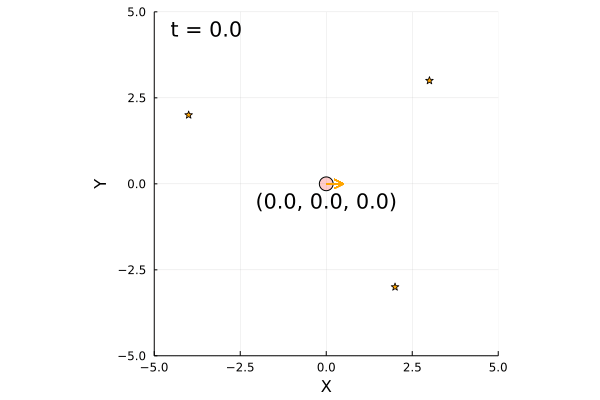

In [4]:
using .FastSlamWorld
using Distributions

function trial(animation=true)

    time_interval = 0.1    
    world = FastSlamWorld.World(30, 0.1)

    ### 地図を生成して2つランドマークを追加 ###
    m = FastSlamWorld.Map()
    FastSlamWorld.append(m, FastSlamWorld.Landmark([-4, 2]))
    FastSlamWorld.append(m, FastSlamWorld.Landmark([2, -3]))
    FastSlamWorld.append(m, FastSlamWorld.Landmark([3, 3]))
    FastSlamWorld.append(world, m)

    initial_pose = [0.0, 0.0, 0.0]
    pf = FastSlamWorld.FastSlam(initial_pose, 100, map=m)
    a = FastSlamWorld.EstimationAgent(time_interval, 0.2, 10.0/180.0*pi, pf)
    r = FastSlamWorld.RealRobot(initial_pose, :red, 0.2, a, sensor=FastSlamWorld.RealCamera(m))
    FastSlamWorld.append(world, r)

    if animation
        FastSlamWorld.draw(world)
    else
        FastSlamWorld.draw(world)
        return pf
    end
end

pf =trial()